# MCMC Adaptive

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from mcmc import *
from mcmc_adaptive import *
from mcmc_plots import (plot_trace_mcmc, plot_marginal_distributions, 
                       plot_autocorrelations, plot_distribution, pairplot)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

plt.rcParams['patch.edgecolor'] = 'black'

In [3]:
DATA_PATH = "GRBs/GRB_data.txt"
arr = np.loadtxt(DATA_PATH, skiprows=1)

### Adaptive + Frozen runs

In [5]:
LOAD = False

rng = np.random.default_rng(1234)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

theta_sim = np.array((theta_true['w'], 
                    theta_true['mu1'], 
                    theta_true['mu2']-theta_true['mu1'], 
                    theta_true['sigma1'],
                    theta_true['sigma2'])) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds
#bounds = [[0,1],[-3,2], [0, 6], [0,4], [0,4]]

bounds = [
    [0.0, 1.0],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [1e-1, 6.0],    # sigma1 (in log-space)
    [1e-1, 6.0]     # sigma2
]

if LOAD == 0:
    n_burnin = 3000
    prop_scale = 0.2    # dev std iniziale per proposta burn-in
    epsilon = 1e-8
    n_steps  = 50000
    sigma_logT90 = 0.0 # se 0: misure senza errore
    
    # 1) inizializzazione parametri
    theta0  = init_theta_from_data(logT90, bounds)
    
    # 1) stima cov durante burnin
    cov_est, mean_est, samples, overall_acc, cov_history = estimate_covariance(
        theta0, logT90, bounds, rng=rng, sigma_logT90=sigma_logT90, 
        max_adapt=20000, adapt_interval=500,  min_adapt=2000, 
        tol_cov=5e-2, eps=1e-8, verbose=True)
    
    samples = metropolis_hastings(mean_est, logT90, bounds, init_cov=cov_est,
                                  rng = rng, sigma_logT90 = sigma_logT90, n = n_steps)
    np.savetxt('chain_adaptive_2.txt',samples)
else:
    samples = np.loadtxt('chain_adaptive_2.txt')

logL (simulation)=  -3730.0687128964673
[adapt t=2000] overall_acc=0.035 acc_window≈0.035 deltaC=2.2632e-01
[adapt t=2500] overall_acc=0.044 acc_window≈0.044 deltaC=1.7816e-01
[adapt t=3000] overall_acc=0.049 acc_window≈0.049 deltaC=1.4714e-01
[adapt t=3500] overall_acc=0.059 acc_window≈0.059 deltaC=1.2022e-01
[adapt t=4000] overall_acc=0.068 acc_window≈0.068 deltaC=1.0802e-01
[adapt t=4500] overall_acc=0.073 acc_window≈0.073 deltaC=8.9906e-02
[adapt t=5000] overall_acc=0.078 acc_window≈0.078 deltaC=8.9953e-02
[adapt t=5500] overall_acc=0.084 acc_window≈0.084 deltaC=7.8850e-02
[adapt t=6000] overall_acc=0.089 acc_window≈0.089 deltaC=6.8648e-02
[adapt t=6500] overall_acc=0.090 acc_window≈0.090 deltaC=6.4012e-02
[adapt t=7000] overall_acc=0.093 acc_window≈0.093 deltaC=6.0055e-02
[adapt t=7500] overall_acc=0.099 acc_window≈0.099 deltaC=5.9392e-02
[adapt t=8000] overall_acc=0.102 acc_window≈0.102 deltaC=5.2112e-02
[adapt t=8500] overall_acc=0.104 acc_window≈0.104 deltaC=4.7610e-02
Adattame

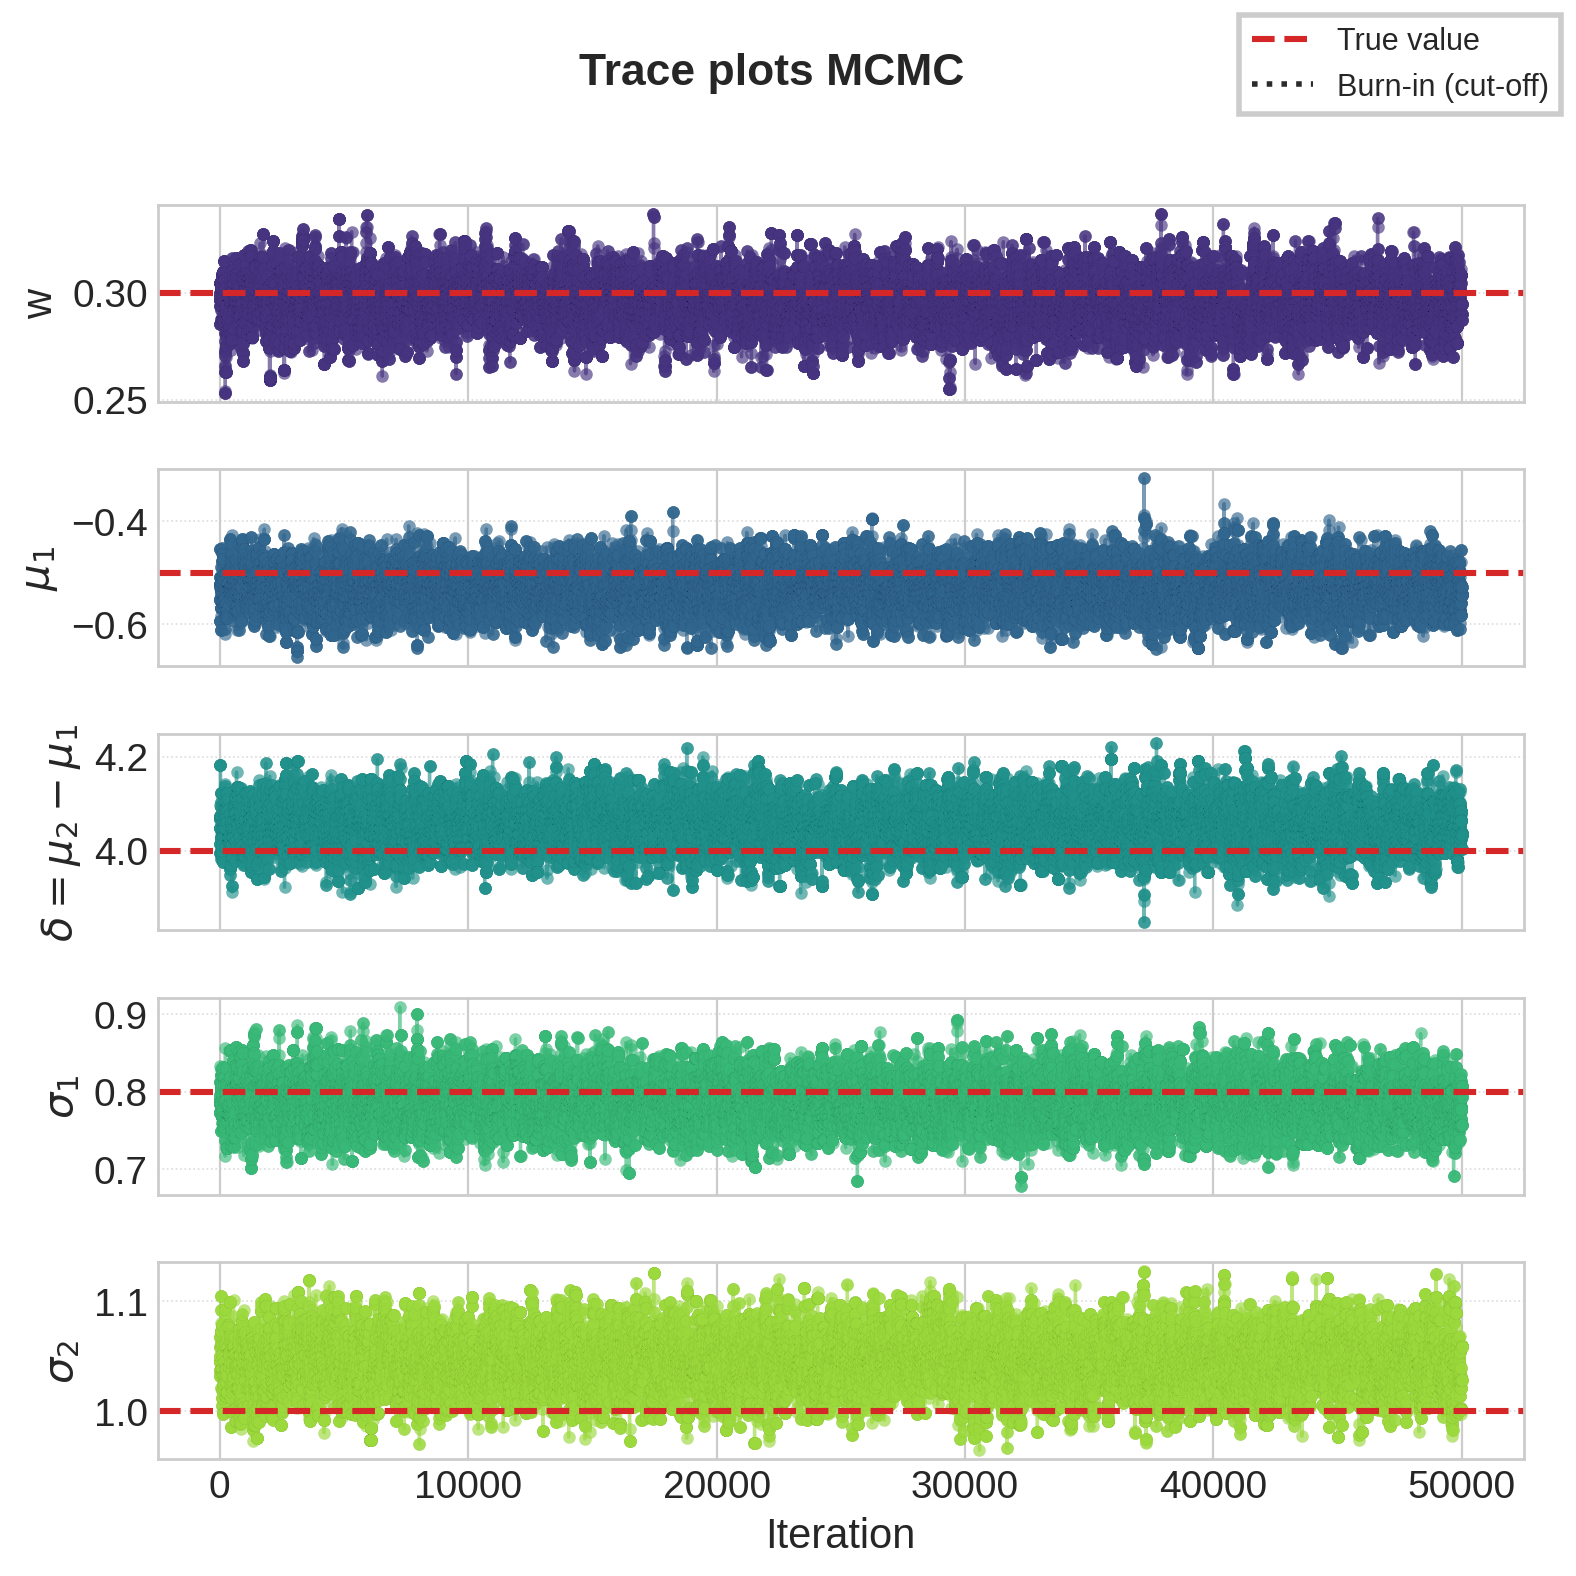

In [71]:
filename = 'trace_plot_mcmc_frozen'
fig, axes = plot_trace_mcmc(samples, filename, theta_sim, burnin=None, save=False)

In [7]:
burnin = 0
samples_new = samples[burnin:,:]

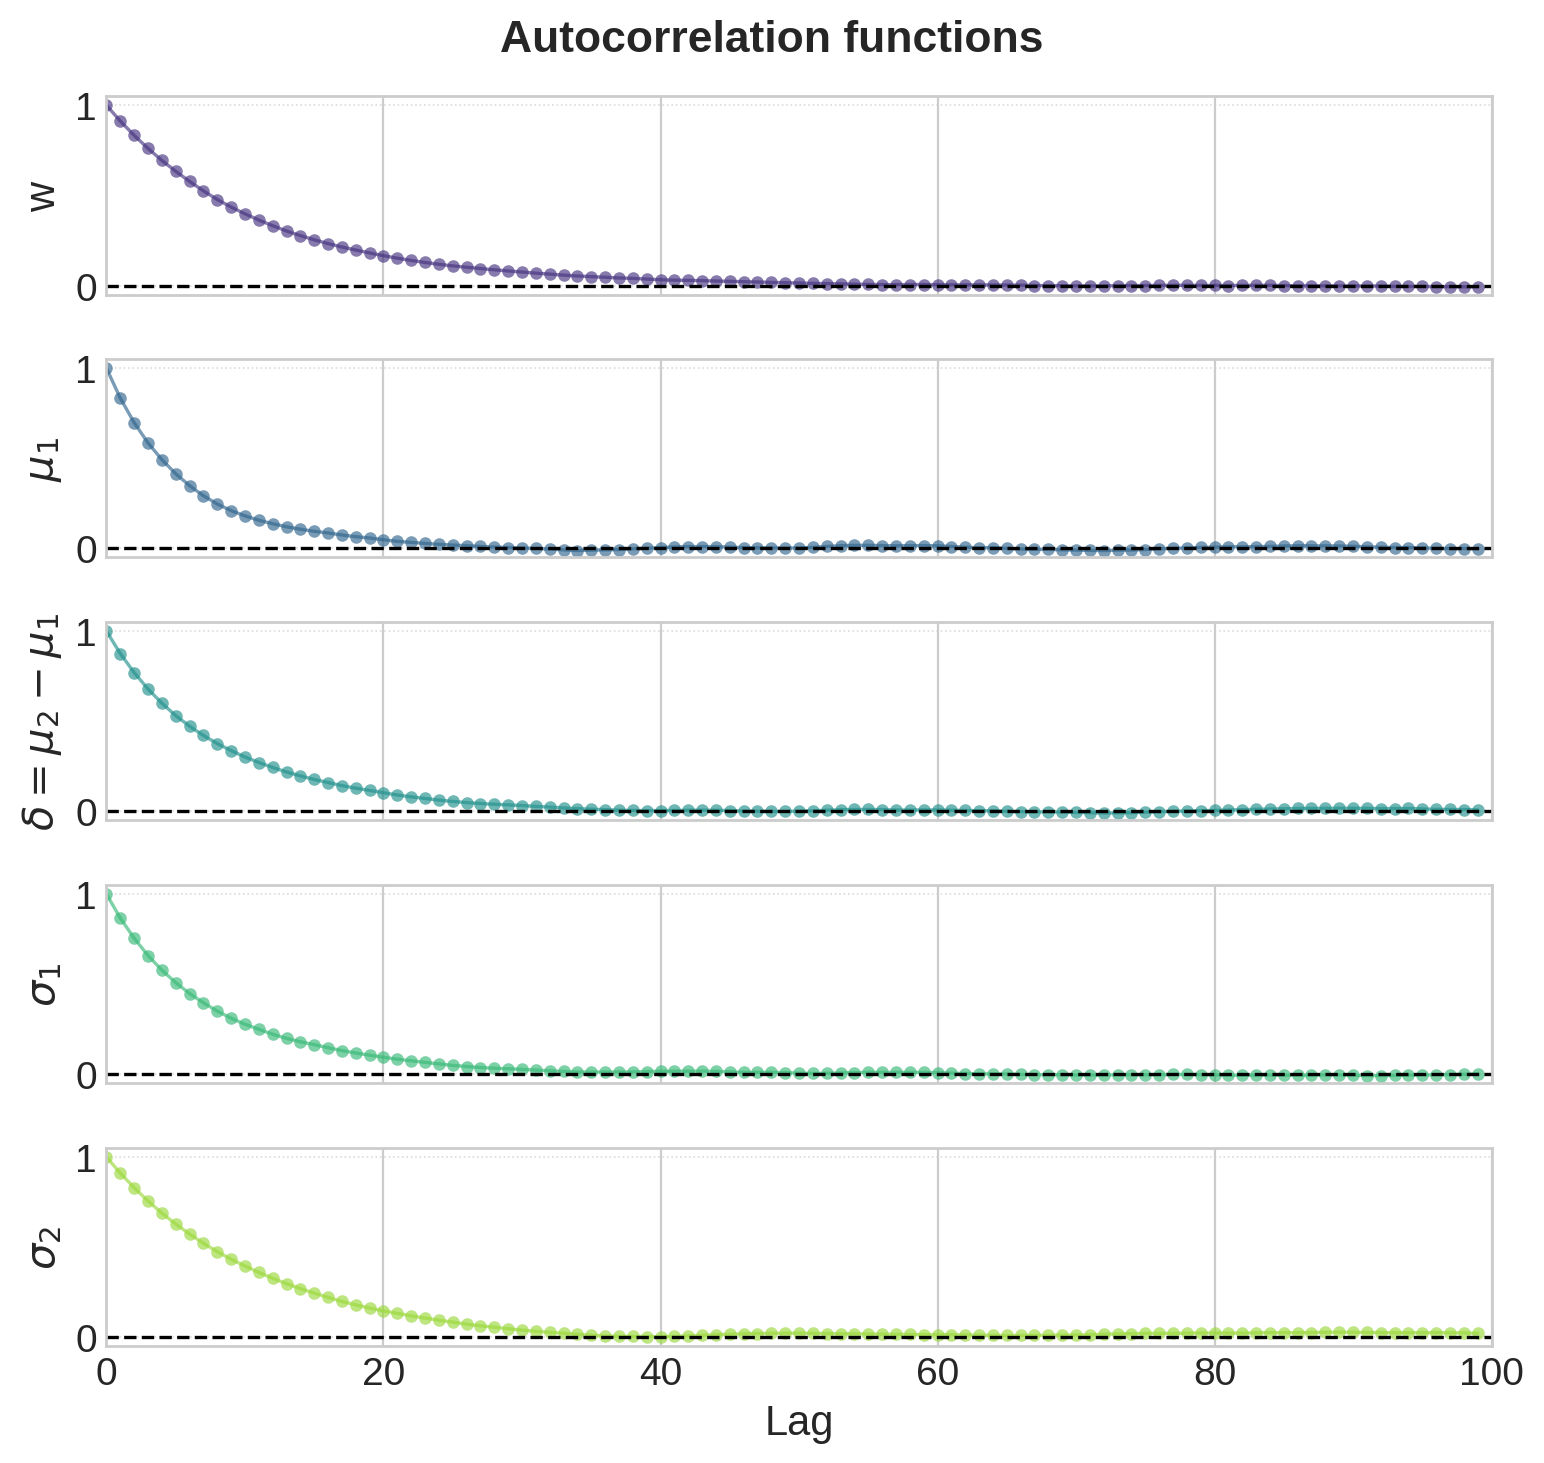

In [73]:
filename = 'autocorrelation_mcmc_frozen'
fig3, axes3 = plot_autocorrelations(samples_new, filename, max_lag=100, save=False)

In [74]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 2240
N_ESS (mu1) = 4210
N_ESS (mu2) = 2998
N_ESS (sigma1) = 3068
N_ESS (sigma2) = 2175


In [10]:
cov_est_final = np.cov(samples_new, rowvar=False)
print('covarianza =\n', cov_est_final)

mean_est_final = np.mean(samples_new, axis=0)

covarianza =
 [[ 1.19973201e-04  5.55575269e-05 -1.66731655e-05  4.70572726e-05
  -3.46339707e-05]
 [ 5.55575269e-05  1.37076274e-03 -1.18144259e-03  2.67440873e-04
  -1.81596859e-04]
 [-1.66731655e-05 -1.18144259e-03  1.95853335e-03 -1.13380447e-04
   2.83943032e-05]
 [ 4.70572726e-05  2.67440873e-04 -1.13380447e-04  8.53511610e-04
  -1.42927788e-04]
 [-3.46339707e-05 -1.81596859e-04  2.83943032e-05 -1.42927788e-04
   5.78326697e-04]]


In [11]:
thinning = 25
samples_new = samples_new[::thinning,:]
samples_new.shape

(2000, 5)

/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


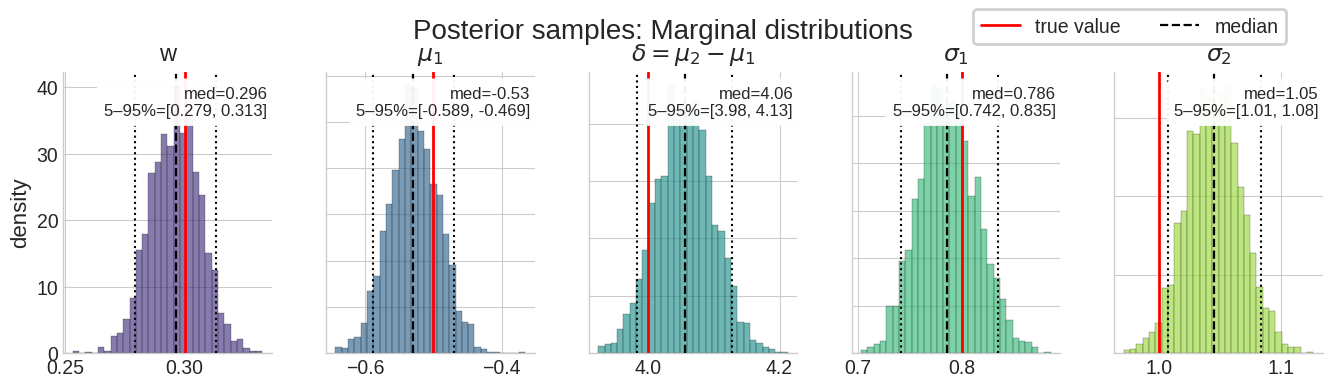

In [77]:
filename = 'marginal_distribution_mcmc_frozen'
fig2, axes2 = plot_marginal_distributions(samples_new, filename, theta_sim, save=False)

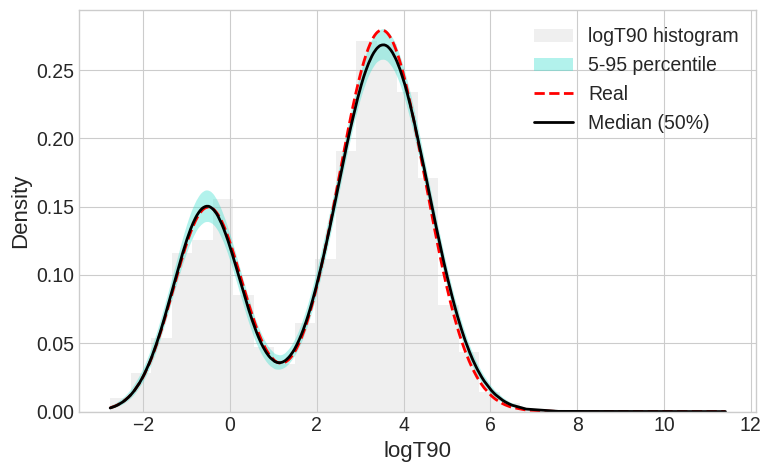

In [78]:
filename = 'distribution_mcmc_frozen'
fig4, axes4 = plot_distribution(logT90, samples_new, filename, theta_true=theta_sim, save=False)

### Final run

In [12]:
if LOAD == 0:
    samples = metropolis_hastings(mean_est_final, logT90, bounds, init_cov=cov_est_final,
                              rng = rng, sigma_logT90 = sigma_logT90, n = n_steps)
    np.savetxt('chain_final.txt',samples)
else:
    samples = np.load('chain_final.txt')

iteration 0: acceptance 0.5
iteration 2500: acceptance 0.3057553956834532
iteration 5000: acceptance 0.30607756897241106
iteration 7500: acceptance 0.3127166089042922
iteration 10000: acceptance 0.3088382323535293
iteration 12500: acceptance 0.3063509838425852
iteration 15000: acceptance 0.3081589121450473
iteration 17500: acceptance 0.3100217118043652
iteration 20000: acceptance 0.30956904309569044
iteration 22500: acceptance 0.3107723757888188
iteration 25000: acceptance 0.3119750419966403
iteration 27500: acceptance 0.31066831503163406
iteration 30000: acceptance 0.3109126058262782
iteration 32500: acceptance 0.31041166697434003
iteration 35000: acceptance 0.31118221815896235
iteration 37500: acceptance 0.3107834248840062
iteration 40000: acceptance 0.3105344732763362
iteration 42500: acceptance 0.310126582278481
iteration 45000: acceptance 0.3111639482689658
iteration 47500: acceptance 0.31196581196581197
Adaptive Metropolis finished. Acceptance rate = 0.3114


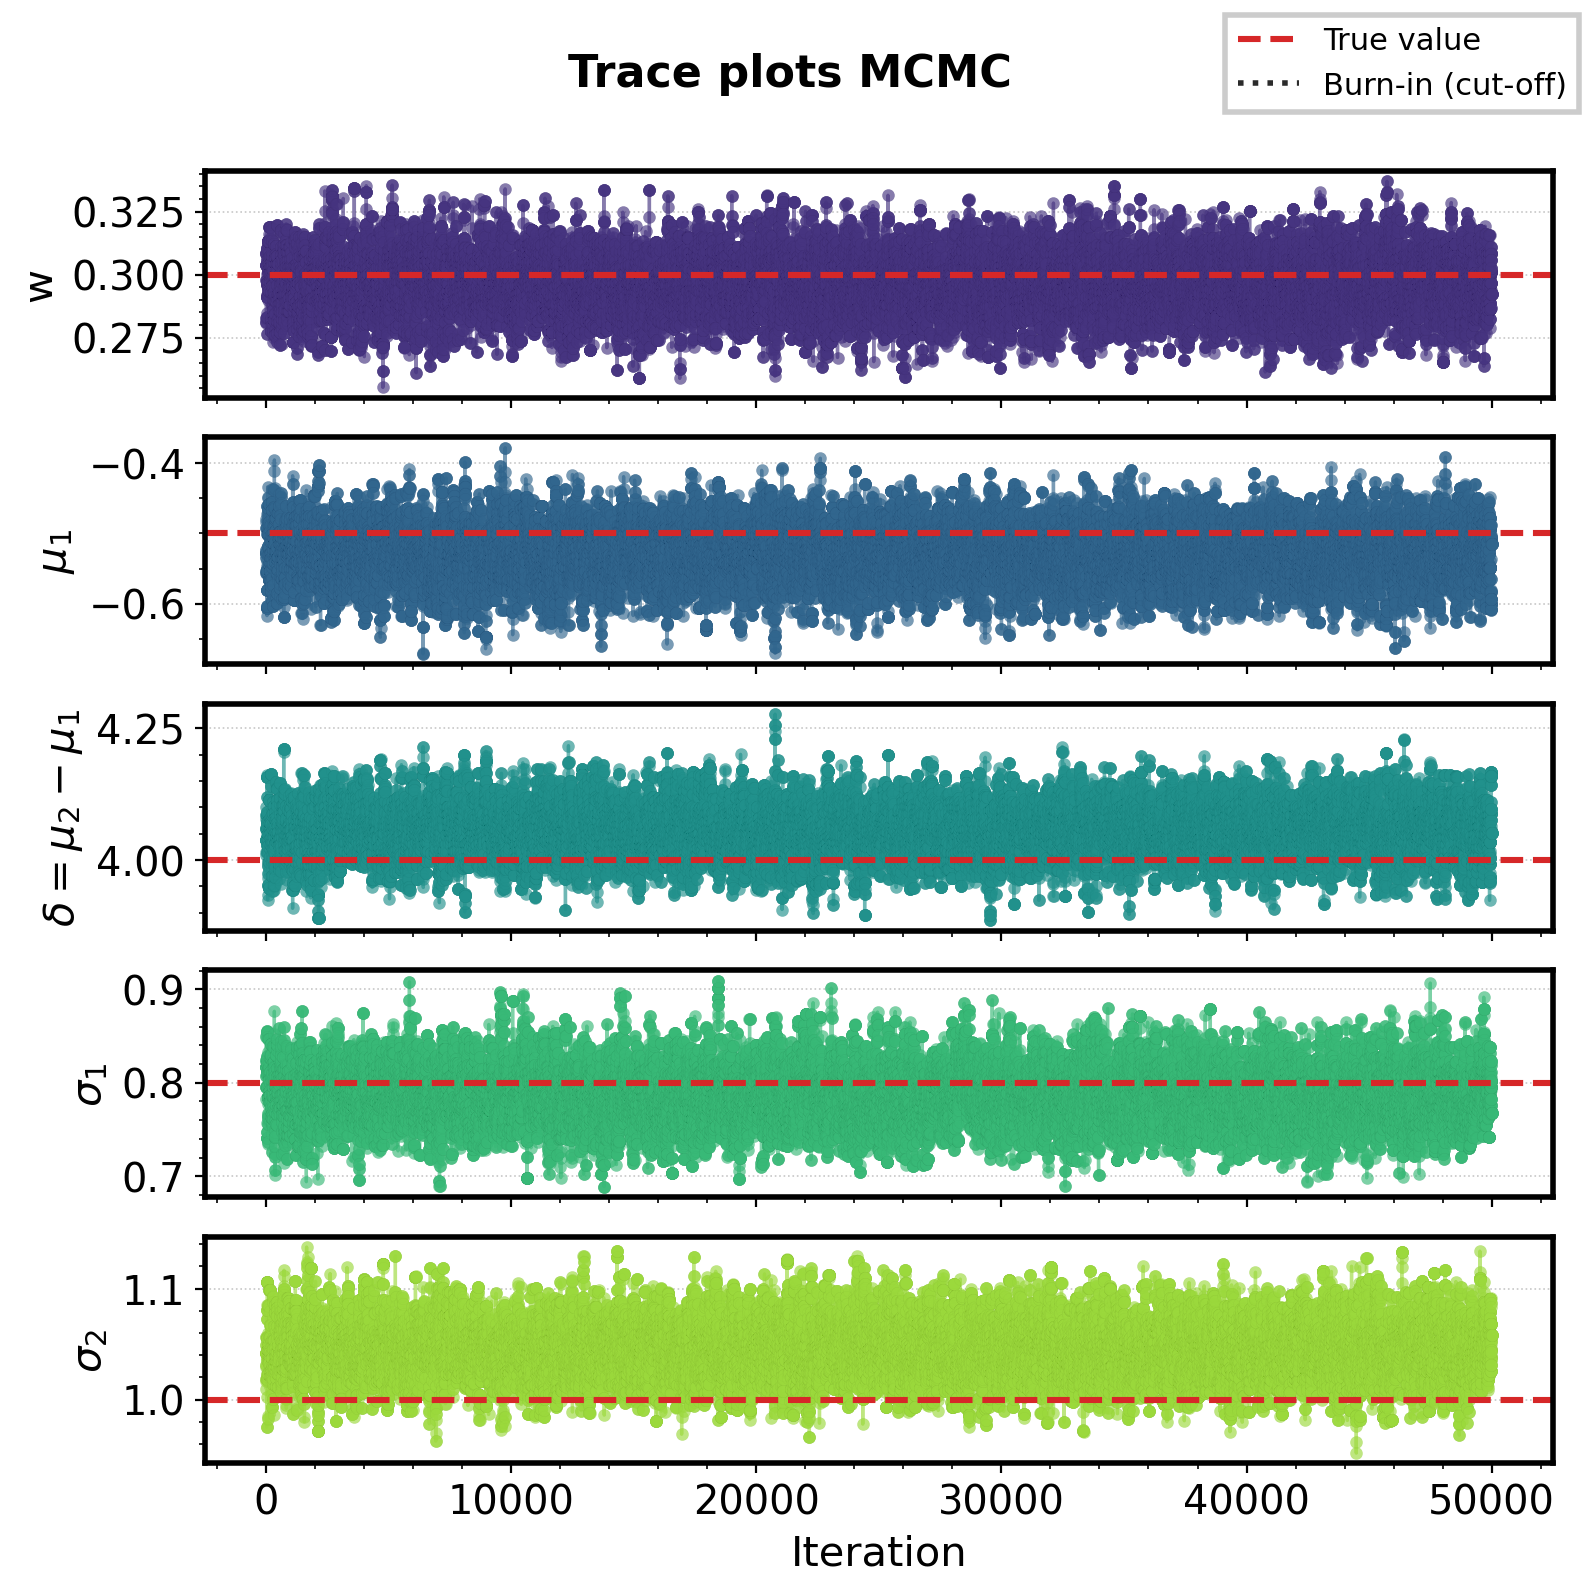

In [13]:
filename = 'trace_plot_mcmc_final'
fig, axes = plot_trace_mcmc(samples, filename, theta_sim, burnin=None, save=False)

In [14]:
burnin = 0
samples_new = samples[burnin:,:]

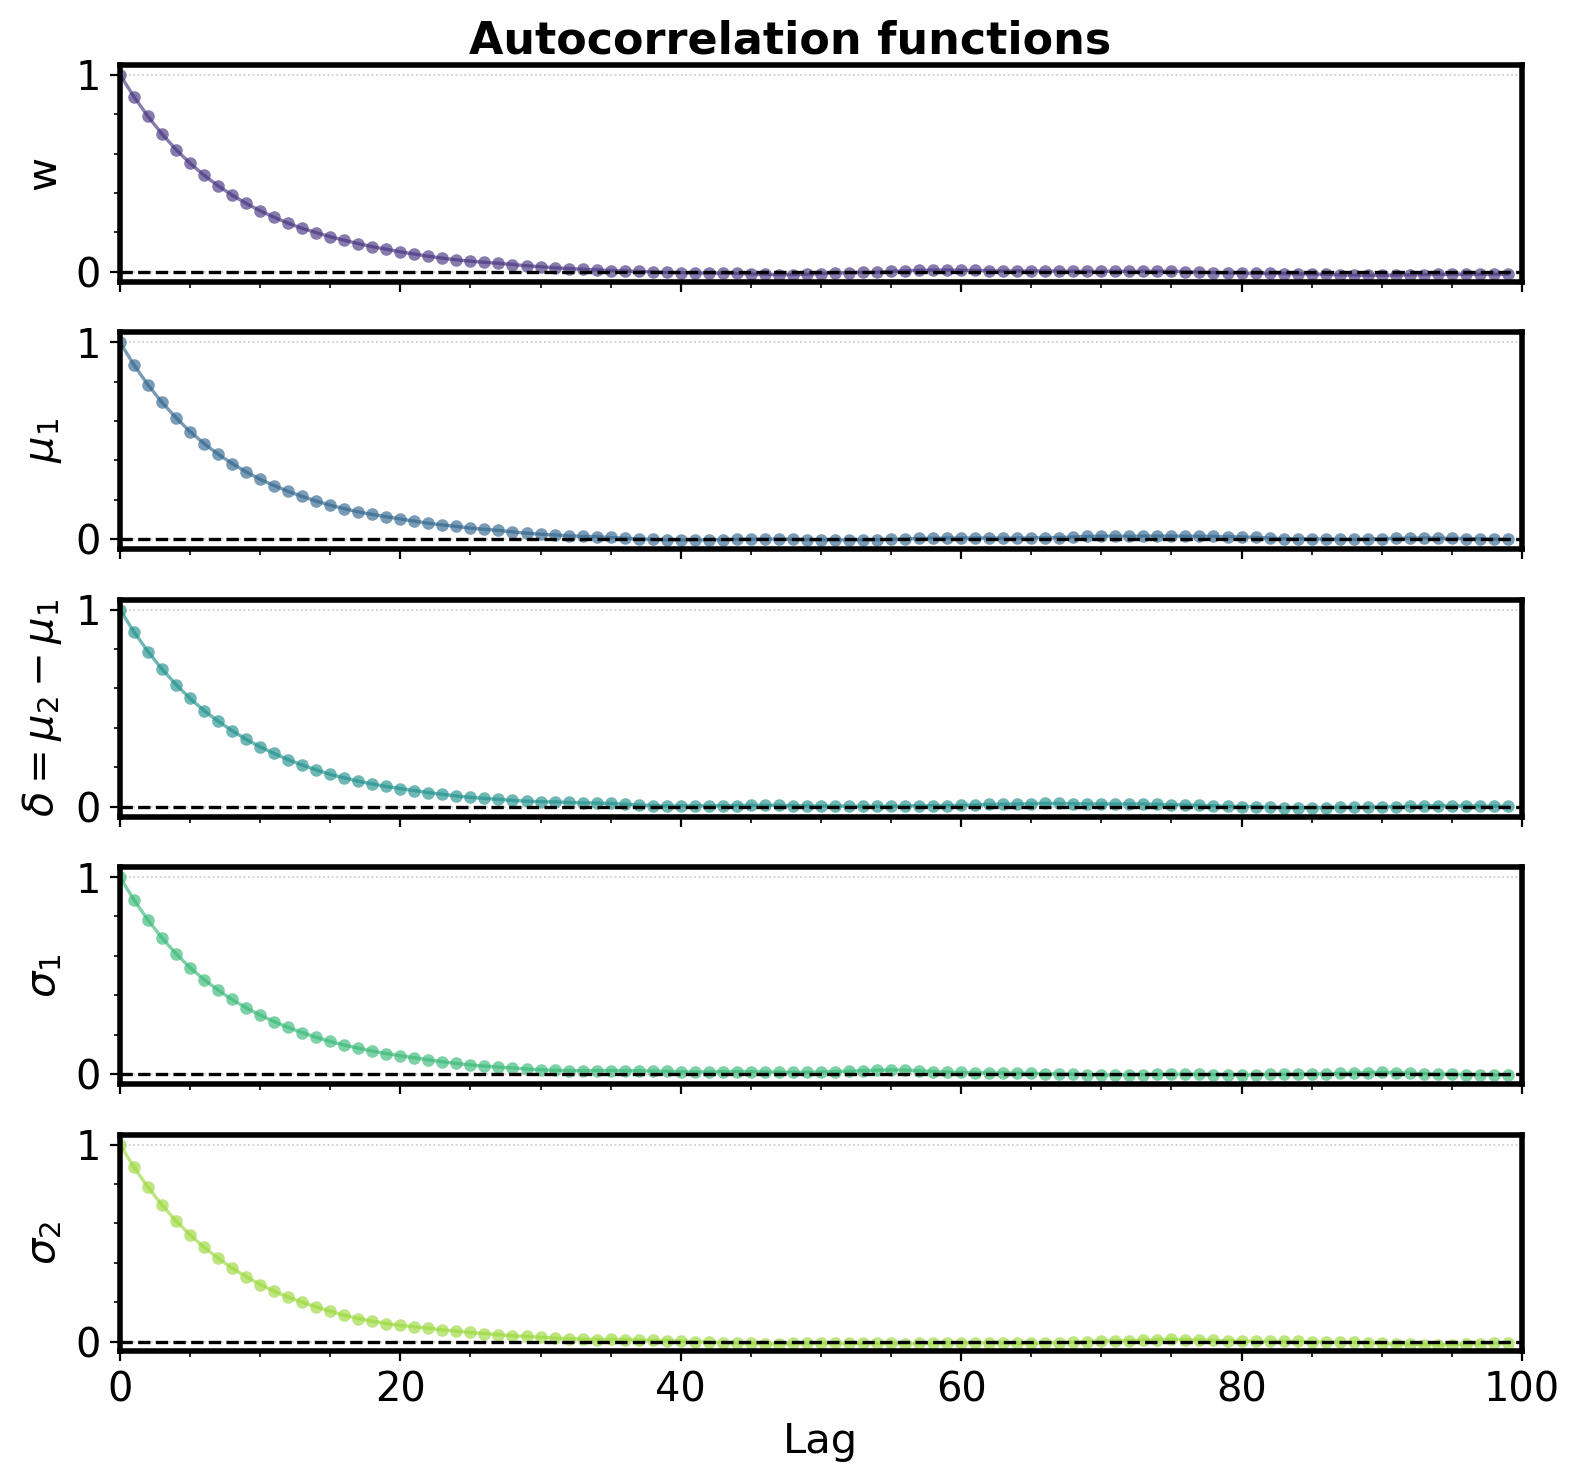

In [15]:
filename = 'autocorrelation_mcmc_final'
fig3, axes3 = plot_autocorrelations(samples_new, filename, max_lag=100, save=False)

In [16]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 2979
N_ESS (mu1) = 2996
N_ESS (mu2) = 2912
N_ESS (sigma1) = 2929
N_ESS (sigma2) = 3123


In [17]:
print('covarianza =\n', cov_est_final)
print('\ncovarianza final =\n', np.cov(samples_new, rowvar=False))

covarianza =
 [[ 1.19973201e-04  5.55575269e-05 -1.66731655e-05  4.70572726e-05
  -3.46339707e-05]
 [ 5.55575269e-05  1.37076274e-03 -1.18144259e-03  2.67440873e-04
  -1.81596859e-04]
 [-1.66731655e-05 -1.18144259e-03  1.95853335e-03 -1.13380447e-04
   2.83943032e-05]
 [ 4.70572726e-05  2.67440873e-04 -1.13380447e-04  8.53511610e-04
  -1.42927788e-04]
 [-3.46339707e-05 -1.81596859e-04  2.83943032e-05 -1.42927788e-04
   5.78326697e-04]]

covarianza final =
 [[ 1.19986707e-04  4.65639972e-05 -3.48736032e-08  4.99675429e-05
  -4.27347298e-05]
 [ 4.65639972e-05  1.35030795e-03 -1.16962496e-03  2.81228738e-04
  -1.71302435e-04]
 [-3.48736032e-08 -1.16962496e-03  1.94067236e-03 -1.36276725e-04
   2.28487255e-05]
 [ 4.99675429e-05  2.81228738e-04 -1.36276725e-04  8.15553879e-04
  -1.34336693e-04]
 [-4.27347298e-05 -1.71302435e-04  2.28487255e-05 -1.34336693e-04
   5.59427911e-04]]


In [85]:
thinning = 20
samples_new = samples_new[::thinning,:]
samples_new.shape

(2500, 5)

/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


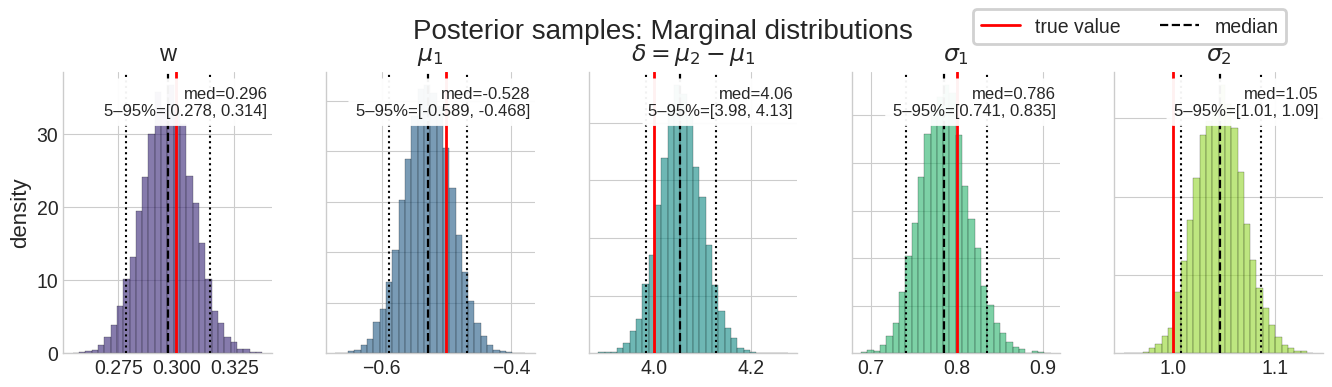

In [18]:
filename = 'marginal_distribution_mcmc_final'
fig2, axes2 = plot_marginal_distributions(samples_new, filename, theta_sim, save=False)

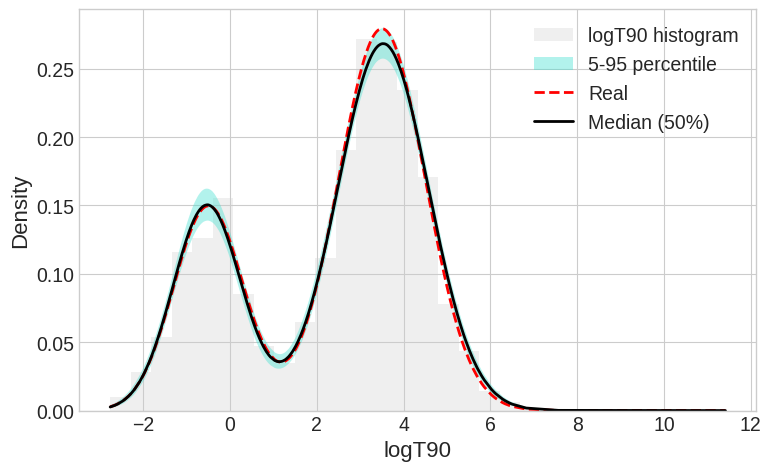

In [19]:
filename = 'distribution_mcmc_final'
fig4, axes4 = plot_distribution(logT90, samples_new, filename, theta_true=theta_sim, save=False)

/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:706: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ]


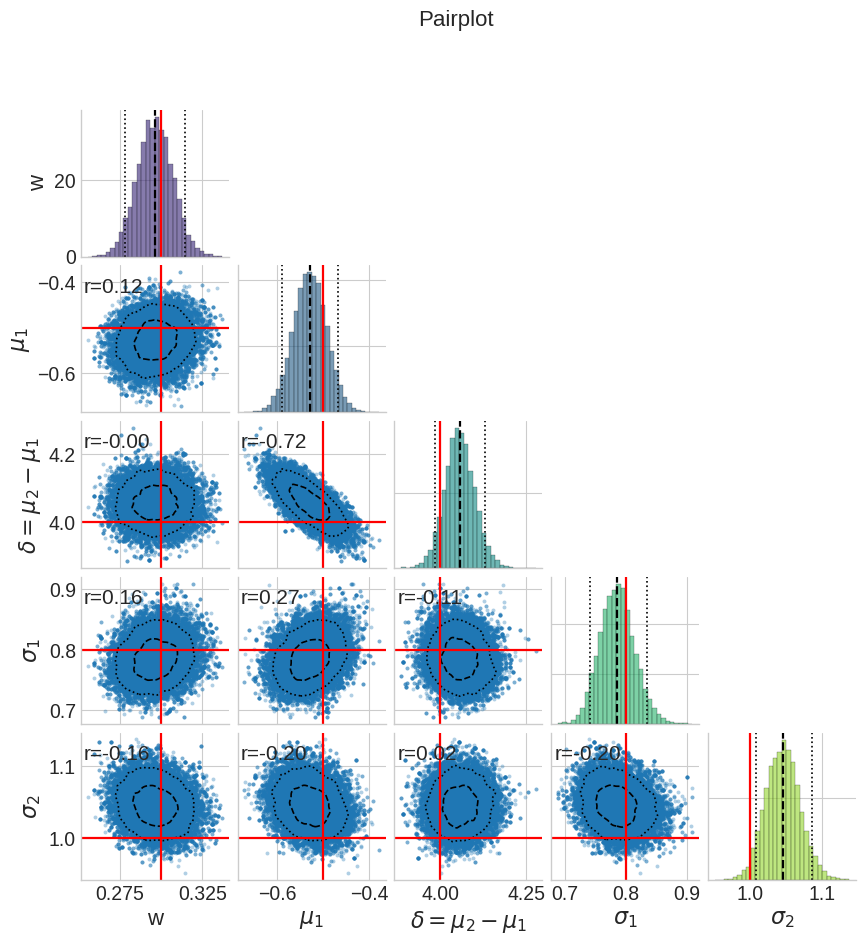

In [51]:
filename = 'Pairplot'
fig5, axes5 = pairplot(samples_new, filename, theta_sim, save=True)